# Контекст

Для контекста есть смысл получать кварталы буквально на этапе создания проекта, так как контекст не зависит от сценария. Также это поможет избежать большого времени создания слоя городских кварталов с дополнительной информацией.

ВАЖНО: 
- Кварталы контекста получаем для выбранного `project_id`.
- Стараемся работать в `crs` от `context_boundaries`.

In [52]:
import geopandas as gpd
import pandas as pd
import prostor.fetchers.projects as projects
import prostor.fetchers.territories as territories
from blocksnet.config import log_config

log_config.set_logger_level('WARNING')

In [2]:
PROJECT_ID = 120

## Вспомогательный код

### 1. Получение слоя городских кварталов

Метод `close_gaps` необходим для дружбы геометрий дорог, которые граничат рядом но не соприкасаются на перекрестках точь-в-точь.

Так как мы не хотим цеплять всю библиотеку `momepy` ради одного метода, мы просто честно его скопируем.

In [3]:
import shapely
import numpy as np

def close_gaps(gdf, tolerance): # taken from momepy
    geom = gdf.geometry.array
    coords = shapely.get_coordinates(geom)
    indices = shapely.get_num_coordinates(geom)

    edges = [0]
    i = 0
    for ind in indices:
        ix = i + ind
        edges.append(ix - 1)
        edges.append(ix)
        i = ix
    edges = edges[:-1]
    points = shapely.points(np.unique(coords[edges], axis=0))

    buffered = shapely.buffer(points, tolerance / 2)

    dissolved = shapely.union_all(buffered)

    exploded = [
        shapely.get_geometry(dissolved, i)
        for i in range(shapely.get_num_geometries(dissolved))
    ]

    centroids = shapely.centroid(exploded)

    snapped = shapely.snap(geom, shapely.union_all(centroids), tolerance)

    return gpd.GeoSeries(snapped, crs=gdf.crs)

In [4]:
from blocksnet.blocks.cutting import preprocess_urban_objects, cut_urban_blocks

BUILDING_POF_ID = 1
WATER_POF_ID = 4
ROADS_POF_ID = 26

LIVING_BUILDING_POT_ID = 4

def _get_project_boundaries(project_id : int):
    return gpd.GeoDataFrame(geometry=[projects.get_project_geometry(project_id)], crs=4326)

def _get_context_boundaries(project_id : int) -> gpd.GeoDataFrame:
    project = projects.get_project(project_id)
    context_ids = project['properties']['context']
    geometries = [territories.get_territory_geometry(territory_id) for territory_id in context_ids]
    return gpd.GeoDataFrame(geometry=geometries, crs=4326)

def _get_context_roads(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_function_id=ROADS_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_context_water(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_function_id=WATER_POF_ID)
    return gdf[['geometry']].reset_index(drop=True)

def _get_context_blocks(project_id : int, boundaries : gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    crs = boundaries.crs
    boundaries.geometry = boundaries.buffer(-1)

    water = _get_context_water(project_id).to_crs(crs)
    roads = _get_context_roads(project_id).to_crs(crs)
    roads.geometry = close_gaps(roads, 1)

    lines, polygons = preprocess_urban_objects(roads, None, water)
    blocks = cut_urban_blocks(boundaries, lines, polygons)
    return blocks

def get_context_blocks(project_id : int):
    project_boundaries = _get_project_boundaries(project_id)
    context_boundaries = _get_context_boundaries(project_id)

    crs = context_boundaries.estimate_utm_crs()
    context_boundaries = context_boundaries.to_crs(crs)
    project_boundaries = project_boundaries.to_crs(crs)

    context_boundaries = context_boundaries.overlay(project_boundaries, how='difference')
    return _get_context_blocks(project_id, context_boundaries)

### 2. Получение слоя функциональных зон

In [5]:
from prostor.adapters import adapt_functional_zones

SOURCES_PRIORITY = ['User', 'PZZ', 'OSM']

def _get_best_functional_zones_source(sources_df : pd.DataFrame) -> tuple[int | None, str | None]:
    sources = sources_df['source'].unique()
    for source in SOURCES_PRIORITY:
        if source in sources:
            sources_df = sources_df[sources_df['source'] == source]
            year = sources_df.year.max()
            return int(year), source
    return None, None #FIXME ??? 

def get_context_functional_zones(project_id : int) -> gpd.GeoDataFrame:
    sources_df = projects.get_functional_zones_sources(project_id)
    year, source = _get_best_functional_zones_source(sources_df)
    functional_zones = projects.get_functional_zones(project_id, year, source)
    return adapt_functional_zones(functional_zones)

### 3. Получение слоя зданий

In [11]:
from prostor.adapters import adapt_buildings
from blocksnet.preprocessing.imputing import impute_buildings

def get_context_buildings(project_id : int):
    gdf = projects.get_physical_objects(project_id, physical_object_type_id=LIVING_BUILDING_POT_ID, centers_only=True)
    gdf = adapt_buildings(gdf.reset_index(drop=True))
    crs = gdf.estimate_utm_crs()
    return impute_buildings(gdf.to_crs(crs)).to_crs(4326)

### 4. Получение слоев сервисов

In [14]:
from prostor.adapters import adapt_services
from blocksnet.preprocessing.imputing import impute_services

def get_context_services(project_id : int, service_types : pd.DataFrame):
    gdf = projects.get_services(project_id, centers_only=True)
    gdfs = adapt_services(gdf.reset_index(drop=True), service_types)
    return {st:impute_services(gdf,st) for st,gdf in gdfs.items()}

## Пайплайн

### 1. Получение слоя городских кварталов

In [35]:
blocks = get_context_blocks(PROJECT_ID)
blocks.head()

,geometry
0,"POLYGON ((391549.648 6642620.924, 391440.516 6..."
1,"POLYGON ((390728.805 6642824.074, 390766.253 6..."
2,"POLYGON ((384619.942 6643780.507, 384592.897 6..."
3,"POLYGON ((383701.245 6643709.235, 384459.417 6..."
4,"POLYGON ((394792.785 6641449.688, 394618.737 6..."


<Axes: >

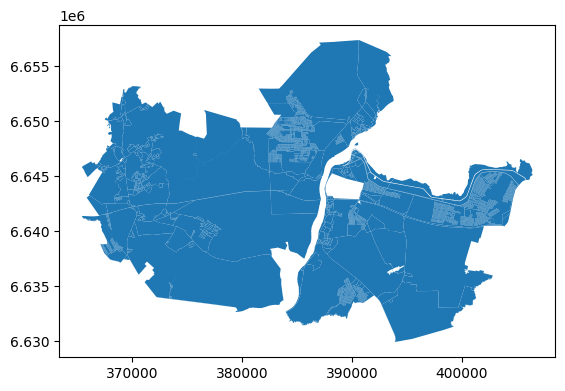

In [36]:
blocks.plot()

### 2. Получение слоя функциональных зон

In [37]:
from prostor.adapters import LAND_USE_RULES
from blocksnet.blocks.assignment import assign_land_use

functional_zones = get_context_functional_zones(PROJECT_ID).to_crs(blocks.crs)
blocks_lu = assign_land_use(blocks, functional_zones, LAND_USE_RULES)
blocks_lu.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((391549.648 6642620.924, 391440.516 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
1,"POLYGON ((390728.805 6642824.074, 390766.253 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
2,"POLYGON ((384619.942 6643780.507, 384592.897 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
3,"POLYGON ((383701.245 6643709.235, 384459.417 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
4,"POLYGON ((394792.785 6641449.688, 394618.737 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN


In [38]:
blocks = blocks.join(blocks_lu.drop(columns=['geometry']))
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share
0,"POLYGON ((391549.648 6642620.924, 391440.516 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
1,"POLYGON ((390728.805 6642824.074, 390766.253 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
2,"POLYGON ((384619.942 6643780.507, 384592.897 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
3,"POLYGON ((383701.245 6643709.235, 384459.417 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN
4,"POLYGON ((394792.785 6641449.688, 394618.737 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN


### 3. Получение слоя зданий 

In [39]:
from blocksnet.blocks.aggregation import aggregate_objects

buildings = get_context_buildings(PROJECT_ID).to_crs(blocks.crs)
blocks_buildings, _ = aggregate_objects(blocks, buildings)
blocks_buildings.head()

,geometry,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population,objects_count
0,"POLYGON ((391549.648 6642620.924, 391440.516 6...",6.0,10.0,2701.5325,3185.5565,2288.37085,897.18565,110.0,6.0
1,"POLYGON ((390728.805 6642824.074, 390766.253 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0
2,"POLYGON ((384619.942 6643780.507, 384592.897 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0
3,"POLYGON ((383701.245 6643709.235, 384459.417 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0
4,"POLYGON ((394792.785 6641449.688, 394618.737 6...",0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0.0


In [40]:
blocks = blocks.join(blocks_buildings.drop(columns=['geometry']).rename(columns={'objects_count' : 'count_buildings'}))
blocks['count_buildings'] = blocks['count_buildings'].fillna(0).astype(int)
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share,is_living,number_of_floors,footprint_area,build_floor_area,living_area,non_living_area,population,count_buildings
0,"POLYGON ((391549.648 6642620.924, 391440.516 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,6.0,10.0,2701.5325,3185.5565,2288.37085,897.18565,110.0,6
1,"POLYGON ((390728.805 6642824.074, 390766.253 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0
2,"POLYGON ((384619.942 6643780.507, 384592.897 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0
3,"POLYGON ((383701.245 6643709.235, 384459.417 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0
4,"POLYGON ((394792.785 6641449.688, 394618.737 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,0.0,0.0,0.0000,0.0000,0.00000,0.00000,0.0,0


### 4. Получение слоев сервисов

In [41]:
service_types = pd.read_pickle('./data/service_types.pickle')
services_dict = get_context_services(PROJECT_ID, service_types)

In [42]:
for service_type, services in services_dict.items():
    services = services.to_crs(blocks.crs)
    blocks_services, _ = aggregate_objects(blocks, services)
    blocks_services['capacity'] = blocks_services['capacity'].fillna(0).astype(int)
    blocks_services['objects_count'] = blocks_services['objects_count'].fillna(0).astype(int)
    blocks = blocks.join(blocks_services.drop(columns=['geometry']).rename(columns={
        'capacity': f'capacity_{service_type}',
        'objects_count': f'count_{service_type}',
    }))

In [43]:
blocks.head()

,geometry,residential,business,recreation,industrial,transport,special,agriculture,land_use,share,...,capacity_supermarket,count_supermarket,capacity_swimming_pool,count_swimming_pool,capacity_train_station,count_train_station,capacity_university,count_university,capacity_veterinary,count_veterinary
0,"POLYGON ((391549.648 6642620.924, 391440.516 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,...,5000,1,1000,1,0,0,0,0,0,0
1,"POLYGON ((390728.805 6642824.074, 390766.253 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,...,0,0,0,0,0,0,0,0,0,0
2,"POLYGON ((384619.942 6643780.507, 384592.897 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,...,0,0,0,0,0,0,0,0,0,0
3,"POLYGON ((383701.245 6643709.235, 384459.417 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,...,0,0,0,0,0,0,0,0,0,0
4,"POLYGON ((394792.785 6641449.688, 394618.737 6...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,None,NaN,...,0,0,0,0,0,0,0,0,0,0


## Результат

В результате получаем слой со столбцами со всех этапов пайплайна:
- **Геометрии кварталов**.
- **Функциональное зонирование** -- доли `residential`, `recreation` и тд, а также наибольший `land_use` и его доля `share`
- **Параметры зданий** -- `population`, `build_floor_area`, `buildings_count` и тд.
- **Параметры сервисов** -- `capacity_{service_type}` и `count_{service_type}`

In [51]:
blocks.to_pickle('./data/context_blocks.pickle')

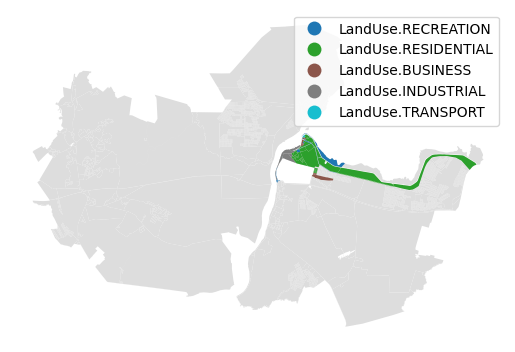

In [47]:
ax = blocks.plot(color='#ddd')
blocks.plot(column='land_use', ax=ax, legend=True).set_axis_off()

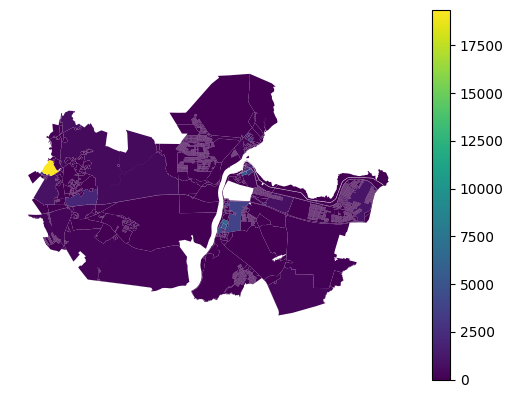

In [49]:
blocks.plot(column='population', legend=True).set_axis_off()

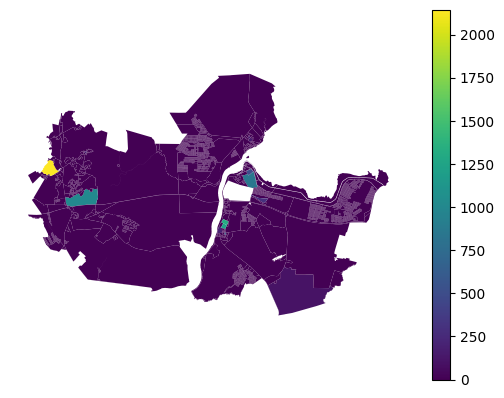

In [50]:
blocks.plot(column='capacity_school', legend=True).set_axis_off()